# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
# import libraries here; add more as necessary

from sklearn.preprocessing import StandardScaler
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There a warning message while reading the datasets. We shall adress this later.

In [37]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [38]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [40]:
print("azdais data size:", azdias.shape)
print("customers data size:", customers.shape)

azdais data size: (891221, 366)
customers data size: (191652, 369)


In [3]:
print(azdias.columns)
print(customers.columns)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)
Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=369)


In [6]:
common_cols = set(azdias.columns).intersection(set(customers.columns))
print(len(list(common_cols)))

366


In [8]:
pc_nans_azidas = azdias.isna().sum()/azdias.shape[0]
pc_nans_customers = customers.isna().sum()/customers.shape[0]

In [34]:
type(pc_nans_azidas)
data = [i for i in pc_nans_azidas]
len(data)

366

6 6


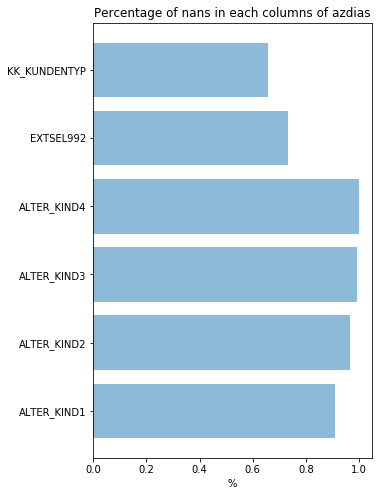

In [39]:
cols = azdias.columns
col_names = [cols[i] for i in range(len(pc_nans_azidas)) if pc_nans_azidas[i]>=0.5 ]
data = [i for i in pc_nans_azidas if i >=0.5]
y_pos = np.arange(len(col_names))
print(len(data), len(y_pos))
f, ax = plt.subplots(figsize=(5,8))
plt.barh(y_pos, data, align='center', alpha=0.5)
plt.yticks(y_pos, col_names)
plt.xlabel('%')
plt.title('Percentage of nans in each columns of azdias')
#fig = plt.figure(figsize=(20,10))
plt.show()

5 5


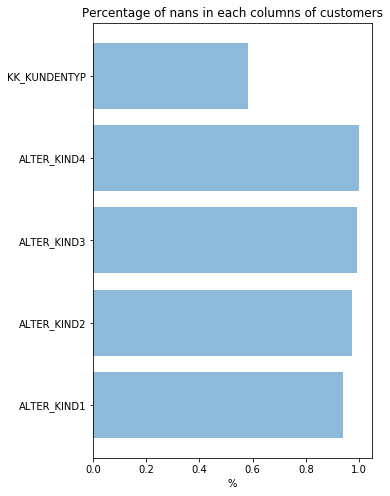

In [38]:
cols = customers.columns
col_names = [cols[i] for i in range(len(pc_nans_customers)) if pc_nans_customers[i]>=0.5 ]
data = [i for i in pc_nans_customers if i >=0.5]
y_pos = np.arange(len(col_names))
print(len(data), len(y_pos))
f, ax = plt.subplots(figsize=(5,8))
plt.barh(y_pos, data, align='center', alpha=0.5)
plt.yticks(y_pos, col_names)
plt.xlabel('%')
plt.title('Percentage of nans in each columns of customers')
#fig = plt.figure(figsize=(20,10))
plt.show()


In [40]:
col_names

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP']

### Remove the above 6 columns since 50% of values are nans.
* 'ALTER_KIND1',
* 'ALTER_KIND2',
* 'ALTER_KIND3',
* 'ALTER_KIND4',
* 'EXTSEL992',
* 'KK_KUNDENTYP'


In [45]:
remove_cols = ['ALTER_KIND1','ALTER_KIND2',
 'ALTER_KIND3','ALTER_KIND4',
 'EXTSEL992','KK_KUNDENTYP']
#azdias.drop(remove_cols, axis=1, inplace=True)
customers.drop(remove_cols, axis=1, inplace=True)

In [52]:
azdias.shape, customers.shape

((891221, 360), (191652, 363))

In [49]:
(azdias.isna().sum(axis=1)>180).sum()

99194

In [50]:
(customers.isna().sum(axis=1)>183).sum()

50743

In [53]:
azdias = azdias[azdias.isna().sum(axis=1)<=180]
customers = customers[customers.isna().sum(axis=1)<=183]

In [54]:
azdias.shape, customers.shape

((792027, 360), (140909, 363))

### Attribution exploration

In [175]:
attributes_values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header=1)
attributes_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1)

In [60]:
#attributes_values[attributes_values.Attribute.str.contains('_AM')].Attribute.unique()
#[attributes_values.Attribute=='CAMEO_INTL_2015']

Drop the index and fill the nan with forward fill `ffill()`

In [61]:
attributes_values.reset_index(drop=True, inplace=True)
attributes_values.ffill(inplace=True)
attributes_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [62]:
print('DIAS Attributes data contains {} attributes.'.format(attributes_values.Attribute.nunique()))

DIAS Attributes data contains 314 attributes.


It seems that most of attributes data are of categorical with multiple values. But there are 7 attributes have only 1 value. Let's have a look of those attributes.

In [63]:
unique_val_cols = list(attributes_values.Attribute.value_counts().index)[-7:]
attributes_values[attributes_values.Attribute.isin(unique_val_cols)]

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,…,numeric value


Fiannly, we observe that there are unknowns in each attribute variable. Let's find out what are the values of unknown value for each attribute and later, we shall replace unknows with nans.

In [64]:
attributes_unknowns = attributes_values.loc[attributes_values.Meaning=='unknown', :][['Attribute', 'Value']]
attributes_unknowns 

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1
51,CAMEO_DEUG_2015,-1
105,CAMEO_DEUINTL_2015,-1
131,CJT_GESAMTTYP,0
391,D19_KK_KUNDENTYP,-1
647,EWDICHTE,-1


In [65]:
attributes_info

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [12]:
attributes_info.reset_index(drop=True, inplace=True)
attributes_info['Information level'].ffill(inplace=True)
attributes_info

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,Person,FINANZ_SPARER,financial typology: money saver,NaN
6,Person,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,Person,FINANZ_ANLEGER,financial typology: investor,NaN
8,Person,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,Person,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [66]:
print('Information levels:')
print(list(attributes_info['Information level'].unique()))

Information levels:
[nan, 'Person', 'Household', 'Building', 'Microcell (RR4_ID)', 'Microcell (RR3_ID)', '125m x 125m Grid', 'Postcode ', 'RR1_ID', 'PLZ8', 'Community']


**Attributes commonality**

Let's see if all the columns in `azdias` and `customer` are in `attributes_values`.

In [67]:
def get_exclusive_cols(df):
    attributes_without_info = []
    for col in df.columns:
        if col not in attributes_values.Attribute.values:
            attributes_without_info.append(col)
    return attributes_without_info

In [68]:
azdias_exclusive_cols = get_exclusive_cols(azdias)
customers_exclusive_cols = get_exclusive_cols(customers)
print("{} columns of azdias are not found in attributes_values:".format(len(azdias_exclusive_cols)))
#print(azdias_exclusive_cols)
print("{} columns of customer are not found in attributes_values:".format(len(customers_exclusive_cols)))
#print(customers_exclusive_cols)

88 columns of azdias are not found in attributes_values:
91 columns of customer are not found in attributes_values:


In [69]:
azdias_exclusive_cols

['LNR',
 'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_

Observing that the columns starting with `D19_BANKEN` in customers_exclusive_cols can be found in attribute_values but with suffix `_RZ`.

In [70]:
cols_D19_with_suffix = attributes_values[attributes_values.Attribute.str.contains('_RZ')].Attribute.unique()

for col in cols_D19_with_suffix:
    s = 0
    new_col = col.replace('_RZ', '')
    if new_col not in azdias_exclusive_cols:
           print(col)
        

D19_BUCH_RZ


In [71]:
attributes_values[attributes_values.Attribute.str.contains('D19')]

,Attribute,Description,Value,Meaning
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
139,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,1,very low activity
140,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,2,low activity
141,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,3,slightly increased activity
142,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,4,increased activity
143,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,5,high activity
144,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,6,very high activity
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
146,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,1,very low activity
147,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,2,low activity



### Replace unknow with NaN

In [72]:
attributes_unknowns.head()

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1


In [177]:
def get_unknown_values(attr):
    """Returns the representation of unkown values"""
    
    unknown = attributes_unknowns[attributes_unknowns["Attribute"] == attr]["Value"]
    unknown = unknown.astype(str).str.cat(sep=",")
    unknown = [int(x) for x in unknown.split(",")]
      
    return list(unknown)

def replace_unknown_with_nan(val,unknown):
    """Replaces unknown values with np.nan values if the value mathes with the unkown representation"""
    if val in unknown:
        return np.nan
    else:
        return val

In [74]:
unknown = get_unknown_values('AGER_TYP')
replace_unknown_with_nan(-1,unknown)

nan

In [195]:
#for col in attributes_unknow.Attribute.values
#azdais.head()
def replace_unknowns(df, attributes_unknowns):

    
    for attr in attributes_unknowns.Attribute.values:
        unknowns = get_unknown_values(attr)
        if (len(unknowns) == 0):
            print("There is no unknowns in attribute {}".format(attr))
        
        if (len(unknowns) > 0) & (attr in df.columns):
            #print("Replacing {} with NaN in Attribute {}.".format(unknowns, attr))
            df[attr] = df[attr].apply(lambda x: replace_unknown_with_nan(x,unknowns))

    return df 

In [76]:
azdias = replace_unknowns(azdias, attributes_unknowns)

Replacing [-1] with NaN in Attribute AGER_TYP.
Replacing [-1, 0] with NaN in Attribute ALTERSKATEGORIE_GROB.
Replacing [-1, 0] with NaN in Attribute ANREDE_KZ.
Replacing [-1] with NaN in Attribute BALLRAUM.
Replacing [-1] with NaN in Attribute CAMEO_DEUG_2015.
Replacing [0] with NaN in Attribute CJT_GESAMTTYP.
Replacing [-1] with NaN in Attribute EWDICHTE.
Replacing [-1] with NaN in Attribute FINANZTYP.
Replacing [-1] with NaN in Attribute FINANZ_ANLEGER.
Replacing [-1] with NaN in Attribute FINANZ_HAUSBAUER.
Replacing [-1] with NaN in Attribute FINANZ_MINIMALIST.
Replacing [-1] with NaN in Attribute FINANZ_SPARER.
Replacing [-1] with NaN in Attribute FINANZ_UNAUFFAELLIGER.
Replacing [-1] with NaN in Attribute FINANZ_VORSORGER.
Replacing [-1, 0] with NaN in Attribute GEBAEUDETYP.
Replacing [-1] with NaN in Attribute HEALTH_TYP.
Replacing [-1, 0] with NaN in Attribute HH_EINKOMMEN_SCORE.
Replacing [-1] with NaN in Attribute INNENSTADT.
Replacing [-1, 9] with NaN in Attribute KBA05_ALTER

Replacing [-1] with NaN in Attribute KBA13_KW_110.
Replacing [-1] with NaN in Attribute KBA13_KW_120.
Replacing [-1] with NaN in Attribute KBA13_KW_121.
Replacing [-1] with NaN in Attribute KBA13_MAZDA.
Replacing [-1] with NaN in Attribute KBA13_MERCEDES.
Replacing [-1] with NaN in Attribute KBA13_MOTOR.
Replacing [-1] with NaN in Attribute KBA13_NISSAN.
Replacing [-1] with NaN in Attribute KBA13_OPEL.
Replacing [-1] with NaN in Attribute KBA13_PEUGEOT.
Replacing [-1] with NaN in Attribute KBA13_RENAULT.
Replacing [-1] with NaN in Attribute KBA13_SEG_GELAENDEWAGEN.
Replacing [-1] with NaN in Attribute KBA13_SEG_GROSSRAUMVANS.
Replacing [-1] with NaN in Attribute KBA13_SEG_KLEINST.
Replacing [-1] with NaN in Attribute KBA13_SEG_KLEINWAGEN.
Replacing [-1] with NaN in Attribute KBA13_SEG_KOMPAKTKLASSE.
Replacing [-1] with NaN in Attribute KBA13_SEG_MINIVANS.
Replacing [-1] with NaN in Attribute KBA13_SEG_MINIWAGEN.
Replacing [-1] with NaN in Attribute KBA13_SEG_MITTELKLASSE.
Replacing [-1

In [77]:
#replace_unknowns(temp, attributes_unknowns)
#azdias.columns
customers = replace_unknowns(customers, attributes_unknowns)

Replacing [-1] with NaN in Attribute AGER_TYP.
Replacing [-1, 0] with NaN in Attribute ALTERSKATEGORIE_GROB.
Replacing [-1, 0] with NaN in Attribute ANREDE_KZ.
Replacing [-1] with NaN in Attribute BALLRAUM.
Replacing [-1] with NaN in Attribute CAMEO_DEUG_2015.
Replacing [0] with NaN in Attribute CJT_GESAMTTYP.
Replacing [-1] with NaN in Attribute EWDICHTE.
Replacing [-1] with NaN in Attribute FINANZTYP.
Replacing [-1] with NaN in Attribute FINANZ_ANLEGER.
Replacing [-1] with NaN in Attribute FINANZ_HAUSBAUER.
Replacing [-1] with NaN in Attribute FINANZ_MINIMALIST.
Replacing [-1] with NaN in Attribute FINANZ_SPARER.
Replacing [-1] with NaN in Attribute FINANZ_UNAUFFAELLIGER.
Replacing [-1] with NaN in Attribute FINANZ_VORSORGER.
Replacing [-1, 0] with NaN in Attribute GEBAEUDETYP.
Replacing [-1] with NaN in Attribute HEALTH_TYP.
Replacing [-1, 0] with NaN in Attribute HH_EINKOMMEN_SCORE.
Replacing [-1] with NaN in Attribute INNENSTADT.
Replacing [-1, 9] with NaN in Attribute KBA05_ALTER

Replacing [-1] with NaN in Attribute KBA13_KW_110.
Replacing [-1] with NaN in Attribute KBA13_KW_120.
Replacing [-1] with NaN in Attribute KBA13_KW_121.
Replacing [-1] with NaN in Attribute KBA13_MAZDA.
Replacing [-1] with NaN in Attribute KBA13_MERCEDES.
Replacing [-1] with NaN in Attribute KBA13_MOTOR.
Replacing [-1] with NaN in Attribute KBA13_NISSAN.
Replacing [-1] with NaN in Attribute KBA13_OPEL.
Replacing [-1] with NaN in Attribute KBA13_PEUGEOT.
Replacing [-1] with NaN in Attribute KBA13_RENAULT.
Replacing [-1] with NaN in Attribute KBA13_SEG_GELAENDEWAGEN.
Replacing [-1] with NaN in Attribute KBA13_SEG_GROSSRAUMVANS.
Replacing [-1] with NaN in Attribute KBA13_SEG_KLEINST.
Replacing [-1] with NaN in Attribute KBA13_SEG_KLEINWAGEN.
Replacing [-1] with NaN in Attribute KBA13_SEG_KOMPAKTKLASSE.
Replacing [-1] with NaN in Attribute KBA13_SEG_MINIVANS.
Replacing [-1] with NaN in Attribute KBA13_SEG_MINIWAGEN.
Replacing [-1] with NaN in Attribute KBA13_SEG_MITTELKLASSE.
Replacing [-1

In [33]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [78]:
for col in azdias.columns:
    if 'object' in str(azdias[col].dtype):
        print(col)

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def encode_col(df, col):
    
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].fillna('Unknown'))
    return df
    
#azdias['D19_LETZTER_KAUF_BRANCHE'].unique()

In [28]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [80]:
col = 'CAMEO_DEUG_2015'
azdias.loc[azdias[col] =='X',col] = -1

In [81]:
col ='CAMEO_INTL_2015'
azdias.loc[azdias[col] =='XX',col] = -1
#azdias[col].value_counts()

In [88]:
col = 'CAMEO_DEUG_2015'
customers.loc[customers[col] =='X',col] = -1
col ='CAMEO_INTL_2015'
customers.loc[customers[col] =='XX',col] = -1
#customers[col].value_counts()

### Fix warning columns

In [187]:
def fix_col_cameo(df):
    col = 'CAMEO_DEUG_2015'
    df.loc[df[col] =='X',col] = -1
    col ='CAMEO_INTL_2015'
    df.loc[df[col] =='XX',col] = -1
    return df
    

In [82]:
cols = azdias.columns
for col in cols:
    try:
        azdias[col] = azdias[col].astype(float)
    except:
        print(col)
        encode_col(azdias,col)

CAMEO_DEU_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ


In [85]:
cols = customers.columns
cols[:5]

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN'], dtype='object')

### Encoding non-numerical data

In [89]:
cols = customers.columns
for col in cols:
    try:
        customers[col] = customers[col].astype(float)
    except:
        print(col)
        encode_col(customers, col)

D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ
PRODUCT_GROUP
CUSTOMER_GROUP


In [83]:
col ='EINGEFUEGT_AM'
customers[col]

1      2
2      3
3    905
4      3
5      3
Name: EINGEFUEGT_AM, dtype: int64

In [8]:
cols = azdias.columns
for col in cols:
    azdias[col] = azdias[col].astype(float).round(5)
    customers[col] = customers[col].astype(float).round(5)

In [93]:
remove_cols = customers.columns[-3:]
customers.drop(remove_cols , axis=1, inplace=True)
customers.shape

(140909, 360)

### Fill NaN with mean

In [94]:
azdias.fillna(azdias.mean(), inplace=True)
customers.fillna(customers.mean(), inplace=True)

### Normalize data

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
azdias_scaled = scaler.fit(azdias)
customers_scaled = scaler.fit(customers)

In [97]:
azdias_scaled

sklearn.preprocessing.data.MinMaxScaler

In [2]:
customers_scaled = pd.read_pickle('customers_scaled.pkl')
customers_scaled.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP
0,0.050222,0.666667,0.0,0.476190,0.40,0.001912,0.000000,0.0,0.095238,0.002667,...,0.75,0.4,0.166667,0.1,1.000000,1.0,0.875,0.4,0.5,0.0
1,0.750700,0.524676,0.0,0.285714,0.00,0.001912,0.000000,0.0,0.047619,0.002667,...,1.00,0.9,1.000000,1.0,1.000000,1.0,0.250,0.4,0.5,0.0
2,0.750706,0.333333,0.0,0.380952,0.32,0.000000,0.002935,0.0,0.000000,0.002667,...,0.50,0.5,0.250000,0.1,0.653877,1.0,0.875,0.0,0.0,0.0
3,0.750711,0.524676,0.0,0.952381,0.56,0.013384,0.000000,0.0,0.190476,0.018667,...,1.00,0.2,0.333333,0.3,0.200000,1.0,0.375,0.0,1.0,0.0
4,0.750784,0.333333,0.0,0.523810,0.40,0.001912,0.000000,0.0,0.095238,0.002667,...,1.00,0.0,0.083333,0.0,1.000000,1.0,0.125,0.2,0.5,0.0


In [3]:
customers_scaled.shape

(140909, 360)

In [4]:
azdias_scaled = pd.read_pickle('azdias_scaled.pkl')
azdias_scaled.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,4.749406,0.554188,1.0,0.000000,0.84,0.021033,0.0,0.0,0.095238,0.032000,...,1.0,0.7,0.833333,0.9,0.400000,1.0,0.500,0.8,1.0,1.0
1,4.749433,0.554188,1.0,0.809524,0.68,0.019120,0.0,0.0,0.047619,0.018667,...,0.5,0.8,0.666667,0.5,0.400000,1.0,0.250,0.8,1.0,3.0
2,4.749438,0.666667,0.0,0.619048,0.52,0.001912,0.0,0.0,0.000000,0.005333,...,0.0,0.6,0.750000,1.0,0.633105,1.0,0.875,0.4,1.0,4.0
3,4.749516,0.554188,0.0,0.952381,0.56,0.005736,0.0,0.0,0.190476,0.008000,...,0.5,0.2,0.333333,0.3,0.200000,1.0,0.375,0.6,0.5,3.0
4,4.749532,1.000000,0.0,0.476190,0.40,0.009560,0.0,0.0,0.047619,0.005333,...,0.5,0.9,0.500000,0.3,1.000000,1.0,0.875,0.6,1.0,1.0


In [7]:
azdias_scaled.drop(columns=['LNR'],axis=1,inplace=True)
customers_scaled.drop(columns=['LNR'],axis=1, inplace=True)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [15]:
azdias_scaled.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.554188,1.0,0.000000,0.84,0.021033,0.0,0.0,0.095238,0.032000,0.0,...,1.0,0.7,0.833333,0.9,0.400000,1.0,0.500,0.8,1.0,1.0
1,0.554188,1.0,0.809524,0.68,0.019120,0.0,0.0,0.047619,0.018667,0.0,...,0.5,0.8,0.666667,0.5,0.400000,1.0,0.250,0.8,1.0,3.0
2,0.666667,0.0,0.619048,0.52,0.001912,0.0,0.0,0.000000,0.005333,0.0,...,0.0,0.6,0.750000,1.0,0.633105,1.0,0.875,0.4,1.0,4.0
3,0.554188,0.0,0.952381,0.56,0.005736,0.0,0.0,0.190476,0.008000,0.0,...,0.5,0.2,0.333333,0.3,0.200000,1.0,0.375,0.6,0.5,3.0
4,1.000000,0.0,0.476190,0.40,0.009560,0.0,0.0,0.047619,0.005333,0.0,...,0.5,0.9,0.500000,0.3,1.000000,1.0,0.875,0.6,1.0,1.0


### Dimentionality reduction & PCA

In [11]:
from sklearn.decomposition import PCA

def perform_pca(data, n_components=None):
    
    pca = PCA(n_components)
    pca.fit(data)
    data_transformed = pca.transform(data)
    
    return pca, data_transformed

In [12]:
pca_azdias,_ = perform_pca(azdias_scaled, None)

In [52]:
def plot_pca_exp_variance(pca_azdias, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
    y_label = "Explained Variance(%)"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    
    
    
    #plt.axvline(x=160, ymax=azdias_variance[160], color='b')
    #print(azdias_variance[160])
    
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance vs Number of Components")
    ax.grid()
    plt.show()

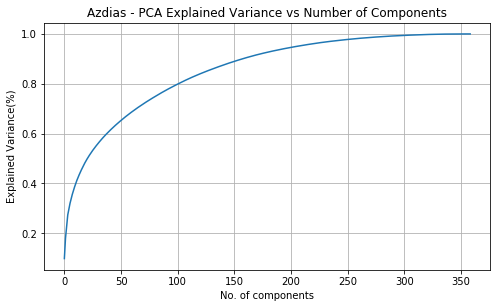

In [53]:
plot_pca_exp_variance(pca_azdias, figsize=(8,10))

In [62]:
np.cumsum(pca_azdias.explained_variance_ratio_)[159]
#pca_azdias.explained_variance_ratio_[:10]

0.9027235701057651

In [63]:
pca_160, azdias_pca_160 = perform_pca(azdias_scaled, n_components=160)

In [66]:
attributes_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1)


In [69]:
def plot_feature_weights(df, pca, attributes_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)

        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

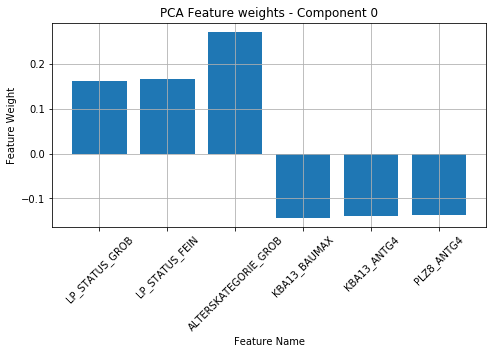

,Feature,Description,FeatureWeight
2,ALTERSKATEGORIE_GROB,age through prename analysis,0.271222
1,LP_STATUS_FEIN,social status fine,0.166222
0,LP_STATUS_GROB,social status rough,0.161264
5,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-0.136024
4,KBA13_ANTG4,No description given,-0.139688
3,KBA13_BAUMAX,No description given,-0.142606


In [70]:
component_0_info = plot_feature_weights(azdias_scaled, pca_azdias, attributes_info, 0, 3)
component_0_info.head(10)

1. This component has positive weight to age, social status (low-income earners)
2. This component has negative weight to number of > 10 family houses
3. has high negative weight to KBA13_ANTG4 and KBA13_BAUMAX, which are sharing of cars with some specification.

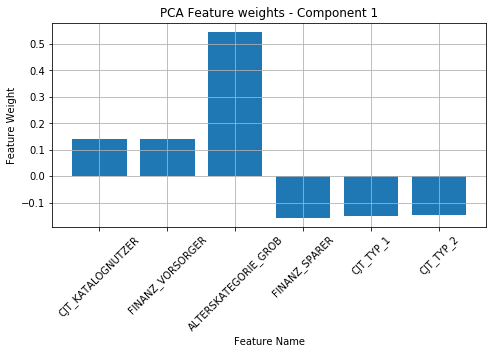

,Feature,Description,FeatureWeight
2,ALTERSKATEGORIE_GROB,age through prename analysis,0.543967
1,FINANZ_VORSORGER,financial typology: be prepared,0.141315
0,CJT_KATALOGNUTZER,No description given,0.139689
5,CJT_TYP_2,No description given,-0.144959
4,CJT_TYP_1,No description given,-0.150085
3,FINANZ_SPARER,financial typology: money saver,-0.156010


In [71]:
component_1_info = plot_feature_weights(azdias_scaled, pca_azdias, attributes_info, 1, 3)
component_1_info.head(10)

1. This component has positive weight to age, people who are financially prepared.
2. This component has hight negative weight to money savers
3. has postive weight to CJT_KATALOGNUTZER, and negative weight to CJT_TYP_1 and CJT_TYP_1, which are Customer-Journey-Typology related features.

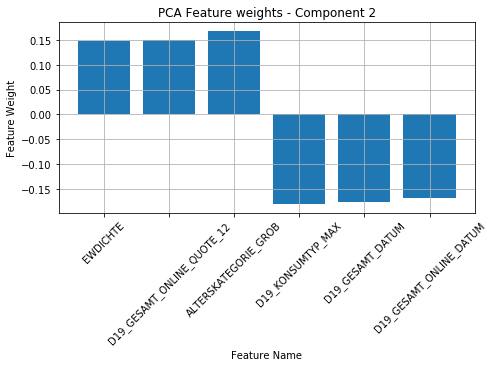

,Feature,Description,FeatureWeight
2,ALTERSKATEGORIE_GROB,age through prename analysis,0.167894
1,D19_GESAMT_ONLINE_QUOTE_12,amount of online transactions within all trans...,0.149928
0,EWDICHTE,density of inhabitants per square kilometer,0.147904
5,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.168027
4,D19_GESAMT_DATUM,actuality of the last transaction with the com...,-0.176263
3,D19_KONSUMTYP_MAX,No description given,-0.180266


In [72]:
component_2_info = plot_feature_weights(azdias_scaled, pca_azdias, attributes_info, 2, 3)
component_2_info.head(10)

1. This component has positive weight to age, people with no Online-transactions within the last 12 months
2. This component has postive weight to density of inhabitants per square kilometer
3. has negative weight to actuality of the last transaction info

## K-Mean clustering

In [80]:
import time
from sklearn.cluster import KMeans

def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [81]:
%%time
scores, range_ = get_Kmeans_scores(azdias_pca_160, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  19304204.047307763
Time elapsed: 158.58 sec.

Training for n_clusters:  3
Done! Score:  18360052.629721273
Time elapsed: 246.70 sec.

Training for n_clusters:  4
Done! Score:  17774143.949743453
Time elapsed: 279.65 sec.

Training for n_clusters:  5
Done! Score:  17414380.945571966
Time elapsed: 326.01 sec.

Training for n_clusters:  6
Done! Score:  17153098.26080972
Time elapsed: 468.64 sec.

Training for n_clusters:  7
Done! Score:  16920665.26188509
Time elapsed: 605.60 sec.

Training for n_clusters:  8
Done! Score:  16741047.674856277
Time elapsed: 548.32 sec.

Training for n_clusters:  9
Done! Score:  16586229.457650766
Time elapsed: 580.54 sec.

Training for n_clusters:  10
Done! Score:  16431555.055255976
Time elapsed: 628.11 sec.

Training for n_clusters:  11
Done! Score:  16310810.165655343
Time elapsed: 738.63 sec.

Training for n_clusters:  12
Done! Score:  16200981.371

In [84]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="g")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("SSE")
    ax.set_title("Average sum of squared errors (SSE) vs number of clusters")
    
    plt.show()

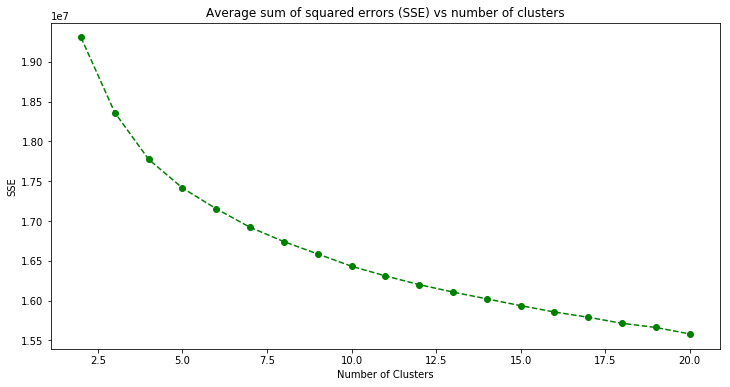

In [85]:
plot_elbow(scores, range_)

In [83]:
from sklearn.externals import joblib
joblib.dump(pca_160, 'pca_160_model.joblib')
joblib.dump(azdias_pca_160, 'azdias_pca_160_model.joblib')
#azdias_pca_160

['azdias_pca_160_model.joblib']

In [87]:
kmeans = KMeans(8)
kmeans.fit(azdias_pca_160)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [88]:
azdias_clusters = kmeans.predict(azdias_pca_160)

In [90]:
customers_pca_160 = pca_160.transform(customers_scaled)
customers_clusters = kmeans.predict(customers_pca_160)

In [91]:
azdias_clusters = pd.Series(azdias_clusters)
customers_clusters = pd.Series(customers_clusters)

In [92]:
azdias_clusters.value_counts().sort_index()

0    113514
1     79711
2     98699
3    124394
4    111063
5    123024
6     66090
7     75532
dtype: int64

In [93]:
customers_clusters.value_counts().sort_index()

0    11870
1    27920
2     6843
3    12284
4    11955
5     3962
6     9387
7    56688
dtype: int64

In [97]:
cluster_info = pd.DataFrame([])
cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)
cluster_info

,Cluster,Population,Customers
0,0,113514,11870
1,1,79711,27920
2,2,98699,6843
3,3,124394,12284
4,4,111063,11955
5,5,123024,3962
6,6,66090,9387
7,7,75532,56688


/Users/hongweiniu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


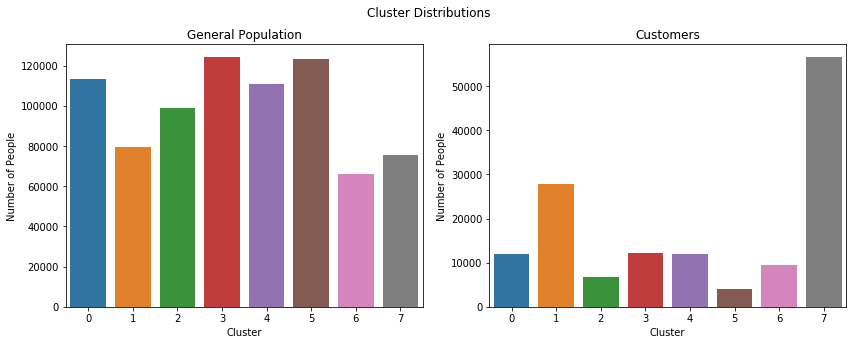

In [115]:
fig, ax =plt.subplots(1,2, figsize=(12, 5))

sns.barplot(x="Cluster", y="Population", data=cluster_info, ax=ax[0])
sns.barplot(x="Cluster", y="Customers", data=cluster_info, ax=ax[1])

ax[0].set_title("General Population")
ax[0].set_ylabel("Number of People")

ax[1].set_title("Customers")
ax[1].set_ylabel("Number of People")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

In [116]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Customer_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

In [137]:
cluster_info['difference'] = cluster_info["Cust_proportion"] - cluster_info["Pop_proportion"]

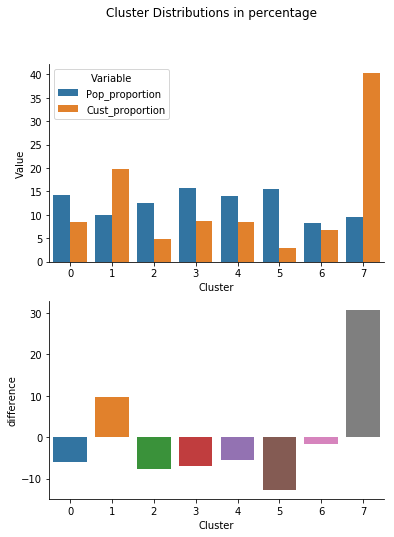

In [160]:
#fig, ax =plt.subplots(figsize=(12, 5))
fig, ax =plt.subplots(2,1, figsize=(6, 8))

fig.suptitle("Cluster Distributions in percentage")
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.show()

data = cluster_info.melt(id_vars='Cluster').rename(columns=str.title)
data = data[data.Variable.str.contains('proportion')]


sns.barplot(x='Cluster', y='Value', hue='Variable', data=data, ax=ax[0])
sns.barplot(x='Cluster', y='difference', data=cluster_info, ax=ax[1])
sns.despine(fig)


1. The distribution of general population is close to uniform.
2. The customers are mostly from clusters 1,7.
3. Cluster 1, 7 are overrepresented and cluster 2, 5 are underrepresented

### What are coluster 1, 7 ?

In [ ]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=2, num_feat_per_comp=3):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [148]:
cluster_1 = explain_cluster(kmeans, 1, azdias_scaled, pca_160, attributes_info)
cluster_1

,Component,ComponentWeight,Feature,Description,FeatureWeight
2,3,1.700794,OST_WEST_KZ,flag indicating the former GDR/FRG,0.179775
1,3,1.700794,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.162115
0,3,1.700794,KBA13_CCM_3001,No description given,0.154886
5,3,1.700794,KBA13_HALTER_25,share of car owners between 21 and 25 within t...,-0.114033
4,3,1.700794,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.116096
3,3,1.700794,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.143252
2,3,1.700794,ALTERSKATEGORIE_GROB,age through prename analysis,0.543967
1,3,1.700794,FINANZ_VORSORGER,financial typology: be prepared,0.141315
0,3,1.700794,CJT_KATALOGNUTZER,No description given,0.139689
5,3,1.700794,CJT_TYP_2,No description given,-0.144959


In [ ]:
cluster_7 = explain_cluster(kmeans, 7, azdias_scaled, pca_160, attributes_info)
cluster_7

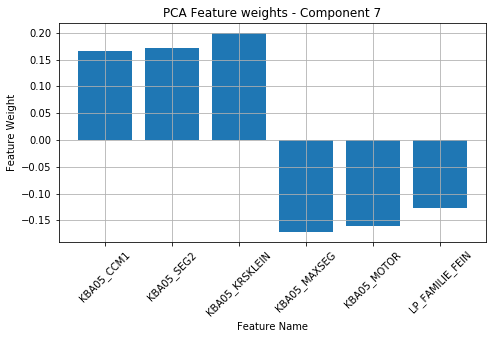

,Feature,Description,FeatureWeight
2,KBA05_KRSKLEIN,share of small cars (referred to the county av...,0.199511
1,KBA05_SEG2,share of small and very small cars (Ford Fiest...,0.172432
0,KBA05_CCM1,share of cars with less than 1399ccm,0.165547
5,LP_FAMILIE_FEIN,family type fine,-0.126319
4,KBA05_MOTOR,most common engine size in the microcell,-0.159824
3,KBA05_MAXSEG,most common car segment in the microcell,-0.172188


In [163]:
plot_feature_weights(azdias_scaled, pca_160, attributes_info, 7, 3)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [223]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv')

/Users/hongweiniu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [224]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [225]:
mailout_train.shape

(42962, 367)

In [226]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

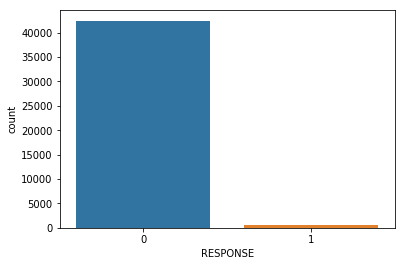

In [227]:
sns.countplot("RESPONSE", data=mailout_train)

In [228]:
labels = mailout_train["RESPONSE"]

In [229]:
def clean_training_data(azdias_cleaned, df, attributes_values):
    
    print("Cleaning Given Dataframe")
    
    start = time.time()
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])
        
    # Ignore if these cols are already cleaned 
    if not (df[warning_cols[0]].dtype == 'float64') & (df[warning_cols[1]].dtype == 'float64'):
        df = fix_col_cameo(df)     

    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
   
    attributes_unknowns = attributes_values.loc[attributes_values.Meaning=='unknown', :][['Attribute', 'Value']]
    df = replace_unknowns(df, attributes_unknowns)
 
    
    # Encoding 
    print("\tEncoding not numerical columns")
    
    cols = customers.columns
    for col in df.columns:
        try:
            df[col] = df[col].astype(float).round(5)
        except:
            encode_col(df, col)
            print("\tFixing column{}".format(col))
     
        
    # Dropping columns which are not in azdias
    print("\tDropping extra columns")
    
    cols_to_drop = [col for col in df.columns if col not in azdias_cleaned.columns]    
    df.drop(columns = cols_to_drop, axis=1, inplace=True)   
    
    # Imputing Missing data
    print("\tImputing missing values with mean")
    df.fillna(df.mean(), inplace=True)
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return df

In [230]:
mailout_train = clean_training_data(azdias_scaled, mailout_train, attributes_values)
mailout_train.shape

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Replacing 'unkown' values with 'NaN'
	Encoding not numerical columns
	Fixing columnCAMEO_DEU_2015
	Fixing columnD19_LETZTER_KAUF_BRANCHE
	Fixing columnEINGEFUEGT_AM
	Fixing columnOST_WEST_KZ
	Dropping extra columns
	Imputing missing values with mean
Completed Cleaning in 7.987062931060791 seconds


(42962, 359)

In [231]:
mailout_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,8.0,8.0,15.0,0.000000,0.0,1.0,13.0,0.0,...,2.0,5.0,2.0,1.0,6.000000,9.0,3.0,3.0,2.0,4.0
1,1.0,4.0,13.0,13.0,1.0,0.000000,0.0,2.0,1.0,0.0,...,3.0,1.0,2.0,1.0,4.000000,9.0,7.0,1.0,2.0,3.0
2,1.0,1.0,9.0,7.0,0.0,0.049574,0.0,0.0,1.0,0.0,...,1.0,6.0,4.0,2.0,4.590321,9.0,2.0,3.0,1.0,4.0
3,2.0,1.0,6.0,6.0,4.0,0.000000,0.0,2.0,4.0,0.0,...,4.0,8.0,11.0,11.0,6.000000,9.0,1.0,3.0,2.0,4.0
4,2.0,1.0,9.0,9.0,53.0,0.000000,0.0,1.0,44.0,0.0,...,4.0,2.0,2.0,1.0,6.000000,9.0,3.0,3.0,1.0,3.0


In [233]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2)

In [242]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """

    model = model.fit(X_train, y_train)
    
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    

    
    
    return roc

In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [244]:
models = [("LogisticRegression", LogisticRegression()),
         ("DecisionTreeClassifier", DecisionTreeClassifier()),
         ("RandomForestClassifier", RandomForestClassifier()),
         ("GradientBoostingClassifier", GradientBoostingClassifier()),
         ("AdaBoostClassifier", AdaBoostClassifier())]

In [246]:
results = {"Model":[],
          "AUCROC_score":[],
          }

for name, model in models:
    roc = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
   

In [247]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score
0,LogisticRegression,0.67614
1,DecisionTreeClassifier,0.486943
2,RandomForestClassifier,0.501053
3,GradientBoostingClassifier,0.77585
4,AdaBoostClassifier,0.754274


In [250]:
scaler = StandardScaler()
mailout_train_scaled = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

In [251]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_scaled, labels, stratify=labels, test_size=0.2)

In [252]:
results_scaled = {"Model":[],
          "AUCROC_score":[],
          }

for name, model in models:
    roc = train_and_predict(model, X_train, y_train, X_val, y_val)
    results_scaled["Model"].append(name)
    results_scaled["AUCROC_score"].append(roc)
results_scaled   

{'Model': ['LogisticRegression',
  'DecisionTreeClassifier',
  'RandomForestClassifier',
  'GradientBoostingClassifier',
  'AdaBoostClassifier'],
 'AUCROC_score': [0.6590556922796463,
  0.48168730866964127,
  0.5033108349951424,
  0.7738394570163913,
  0.7496131708650967]}

In [253]:
results_scaled = pd.DataFrame.from_dict(results_scaled, orient='index').transpose()
results_scaled

,Model,AUCROC_score
0,LogisticRegression,0.659056
1,DecisionTreeClassifier,0.481687
2,RandomForestClassifier,0.503311
3,GradientBoostingClassifier,0.773839
4,AdaBoostClassifier,0.749613


In [255]:
mailout_train_pca = pca_160.transform(mailout_train_scaled)

X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(
    mailout_train_pca, labels, stratify=labels, test_size=0.2)

In [257]:
results_pca = {"Model":[],
          "AUCROC_score":[],
          }

for name, model in models:
    roc = train_and_predict(model, X_train_pca, y_train_pca, X_val_pca, y_val_pca)
    results_pca["Model"].append(name)
    results_pca["AUCROC_score"].append(roc)
results_pca = pd.DataFrame.from_dict(results_pca, orient='index').transpose()
results_pca

,Model,AUCROC_score
0,LogisticRegression,0.67354
1,DecisionTreeClassifier,0.490414
2,RandomForestClassifier,0.491401
3,GradientBoostingClassifier,0.566981
4,AdaBoostClassifier,0.550982


In [261]:
results_all = results.merge(results_scaled, left_on='Model', right_on='Model', how='left')
results_all = results_all.merge(results_pca, left_on='Model', right_on='Model', how='left')
newnames = ['Model', 'AUCROC_score', 'AUCROC_score_scaled','AUCROC_score_pca']
results_all.columns =  newnames
results_all

,Model,AUCROC_score,AUCROC_score_scaled,AUCROC_score_pca
0,LogisticRegression,0.67614,0.659056,0.67354
1,DecisionTreeClassifier,0.486943,0.481687,0.490414
2,RandomForestClassifier,0.501053,0.503311,0.491401
3,GradientBoostingClassifier,0.77585,0.773839,0.566981
4,AdaBoostClassifier,0.754274,0.749613,0.550982


In [264]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv')

/Users/hongweiniu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Use LNR as index.

In [265]:
mailout_test_LNR = mailout_test['LNR']

Clean mailout_test by using function `clean_training_data`.

In [266]:
mailout_test = clean_training_data(azdias_scaled, mailout_test, attributes_values)
mailout_test.shape 

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Replacing 'unkown' values with 'NaN'
	Encoding not numerical columns
	Fixing columnCAMEO_DEU_2015
	Fixing columnD19_LETZTER_KAUF_BRANCHE
	Fixing columnEINGEFUEGT_AM
	Fixing columnOST_WEST_KZ
	Dropping extra columns
	Imputing missing values with mean
Completed Cleaning in 9.766434907913208 seconds


(42833, 359)

In [272]:
X_train.shape, mailout_test.shape

((34369, 359), (42833, 359))

**GradientBoostingClassifier**

In [273]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2)
gboost_model = GradientBoostingClassifier()
gboost_model = gboost_model.fit(X_train, y_train)

gboost_predicts = gboost_model.predict_proba(mailout_test)[:,1]

In [275]:
gboost = pd.DataFrame(index=mailout_test_LNR, data=gboost_predicts)
gboost.rename(columns={0: "RESPONSE"}, inplace=True)

In [276]:
gboost.head()

,RESPONSE
LNR,
1754,0.044866
1770,0.019334
1465,0.004342
1470,0.002961
1478,0.006463


In [278]:
gboost.to_csv('kaggle_submission_gradientboost2.csv')

submission score: 0.79379